In [4]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
import os
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets
from IPython.display import clear_output
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display

# -*- coding: utf-8 -*-

class regression_1dim_sliders:
    
    def __init__(self):
        a = 0
        self.data = []
        self.cost_history = []
        self.x_orig = []
        
    # load in a two-dimensional dataset from csv - input should be in first column, oiutput in second column, no headers 
    def load_data(self,*args):
        # load data
        self.data = np.asarray(pd.read_csv(args[0],header = None))
   
        # center x-value of data
        self.data[:,0] = self.data[:,0] - np.mean(self.data[:,0])
        
        # center y-value of data if not performing logistic regression
        if args[-1] != 'logistic':
            self.data[:,1] = self.data[:,1] - np.mean(self.data[:,1])
        
        # transform input if needed
        self.x_orig = self.data[:,0].copy()
        if len(args) > 1:
            if args[1] == 'sin':
                self.data[:,0] = np.sin(2*np.pi*self.data[:,0])
        
    #### linear regression functions ####    
    def compute_lin_regression_cost(self,x,y,b,w):
        cost = 0
        for p in range(0,len(y)):
            cost +=(b + w*x[p] - y[p])**2
        return cost
                
    # gradient descent function
    def run_lin_regression_grad_descent(self,inits,max_its):    
        # peel off coordinates
        x = self.data[:,0]
        y = self.data[:,1]
        
        # initialize parameters - we choose this special to illustrate whats going on
        b = inits[0]    # initial intercept
        w = inits[1]      # initial slope
        P = len(y)
        
        # plot first parameters on cost surface
        cost_val = self.compute_lin_regression_cost(x,y,b,w)
        self.cost_history = []
        self.cost_history.append([b,w,cost_val])
        
        # gradient descent loop
        for k in range(1,max_its+1):   
            # compute each partial derivative - gprime_b is partial with respect to b, gprime_w the partial with respect to w            
            gprime_b = 0
            gprime_w = 0
            for p in range(0,P):
                temp = 2*(b + w*x[p] - y[p])
                gprime_b += temp
                gprime_w += temp*x[p]
            
            # set alpha via line search
            grad = np.asarray([gprime_b,gprime_w])
            grad.shape = (len(grad),1)
            alpha = self.line_search(x,y,b,w,grad,self.compute_lin_regression_cost)
            
            # take descent step in each partial derivative
            b = b - alpha*gprime_b
            w = w - alpha*gprime_w

            # compute cost function value 
            cost_val = self.compute_lin_regression_cost(x,y,b,w)
            self.cost_history.append([b,w,cost_val])   
      
    #### logistic regression functions ####
    def compute_logistic_regression_cost(self,x,y,b,w):
        cost = 0
        for p in range(0,len(y)):
            cost += np.log(1 + np.exp(-y[p]*(b + x[p]*w)))
        return cost
    
    # gradient descent function for softmax cost/logistic regression 
    def run_logistic_regression_grad_descent(self,inits,max_its):
        # peel off coordinates
        x = self.data[:,0]
        y = self.data[:,1]
        
        # initialize parameters - we choose this special to illustrate whats going on
        b = inits[0]
        w = inits[1]
        P = len(y)
        
        # plot first parameters on cost surface
        cost_val = self.compute_logistic_regression_cost(x,y,b,w)
        self.cost_history = []
        self.cost_history.append([b,w,cost_val])
        
        for k in range(max_its):
            # compute gradient
            gprime_b = 0
            gprime_w = 0
            for p in range(P):
                temp = -1/(1 + np.exp(y[p]*(b + w*x[p])))*y[p]
                gprime_b += temp
                gprime_w += temp*x[p]
            grad = np.asarray([gprime_b,gprime_w])
            grad.shape = (len(grad),1)         
            
            # compute step length via line search
            alpha = self.line_search(x,y,b,w,grad,self.compute_logistic_regression_cost)
    
            # take descent step in each partial derivative
            b = b - alpha*gprime_b
            w = w - alpha*gprime_w

            # compute cost function value 
            cost_val = self.compute_logistic_regression_cost(x,y,b,w)
            self.cost_history.append([b,w,cost_val]) 

            
    #### line search module - used for with both linear regression and logistic regression grad descent functions ####
    def line_search(self,x,y,b,w,grad,cost_fun):
        alpha = 1
        t = 0.1
        g_w = cost_fun(x,y,b,w)
        norm_w = np.linalg.norm(grad)**2
        while cost_fun(x,y,b - alpha*grad[0],w - alpha*grad[1]) > g_w - alpha*0.5*norm_w:
            alpha = t*alpha
        return alpha

    ##### plotting functions ####
    # show the net transformation using slider
    def fitting_slider(self,**args):  
        # pull out coordinates
        x_orig = self.x_orig
        x_tran = self.data[:,0]
        y = self.data[:,1]
        
        ##### precomputations #####
        # precompute fits input
        x_fit = np.linspace(np.min(x_orig)-1, np.max(x_orig)+1, 100)
        
        # precompute surface 
        xs = max([abs(v[0]) for v in self.cost_history])
        ys = max([abs(v[1]) for v in self.cost_history])
        minval = min(-xs,-ys)
        maxval = max(xs,ys)
        gap = (maxval - minval)*0.2
        r = np.linspace(minval - gap, maxval + gap)    
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))

        # generate surface based on given data - done very lazily - recomputed each time
        g = 0
        P = len(y)
        if args['fit_type'] == 'line fit' or args['fit_type'] == 'sine fit':
            for p in range(0,P):
                g+= (s + t*x_tran[p] - y[p])**2
        if args['fit_type'] == 'logistic fit':
            for p in range(0,P):
                g+= np.log(1 + np.exp(-y[p]*(s + t*x_tran[p])))

        # reshape and plot the surface, as well as where the zero-plane is
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        g.shape = (np.size(r),np.size(r))
        
        # slider mechanism
        def show_fit(step):
            # setup figure to plot
            fig = plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')

            ### initialize plot data points and fit
            # initialize fit
            vals = self.cost_history[step]
            b = vals[0]
            w = vals[1]
            yfit = 0
            # transform input if needed for plotting
            if args['fit_type'] == 'line fit':
                y_fit = b + x_fit*w
            if args['fit_type'] == 'sine fit':
                y_fit = b + np.sin(2*np.pi*x_fit)*w
            if args['fit_type'] == 'logistic fit':
                y_fit = np.tanh(b + x_fit*w)

            # plot fit to data
            ax1 = plt.subplot(121)
            ax1.plot(x_fit,y_fit,'-r',linewidth = 3) 

            # initialize points
            ax1.scatter(x_orig,y)

            # clean up panel
            xgap = float(max(x_orig) - min(x_orig))/float(10)
            ax1.set_xlim([min(x_orig)-xgap,max(x_orig)+xgap])
            ygap = float(max(y) - min(y))/float(10)
            ax1.set_ylim([min(y)-ygap,max(y)+ygap])
            ax1.set_xticks([])
            ax1.set_yticks([])

            ### plot surface
            ax2 = plt.subplot(122,projection='3d')
            ax2.plot_surface(s,t,g,alpha = 0.15)
            ax2.plot_surface(s,t,g*0,alpha = 0.1)

            # plot all gradient descent steps faintly for visualization purposes
            bs = []
            ws = []
            costs = []
            for i in range(len(self.cost_history)):
                bwg = self.cost_history[i]
                b = bwg[0]
                w = bwg[1]
                cost = bwg[2]
                bs.append(b)
                ws.append(w)
                costs.append(cost)
            ax2.scatter(bs,ws,costs,color = 'm',marker = 'x',linewidth = 3, alpha = 0.1)            

            # plot current gradient descent step in bright red
            b = vals[0]
            w = vals[1]
            cost = vals[2]
            ax2.scatter(b,w,cost,marker = 'o',color = 'r',s = 50,edgecolor = 'k',linewidth = 1)            
            
            # clean up panel
            ax2.view_init(args['view'][0],args['view'][1])        
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_zticks([])

            ax2.set_xlabel(args['xlabel'],fontsize = 14,labelpad = -5)
            ax2.set_ylabel(args['ylabel'],fontsize = 14,labelpad = -5)

            ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
            ax2.set_zlabel('cost  ',fontsize = 14, rotation = 0,labelpad = 1)
    
        interact(show_fit, step=widgets.IntSlider(min=0,max=len(self.cost_history)-1,step=1,value=0))

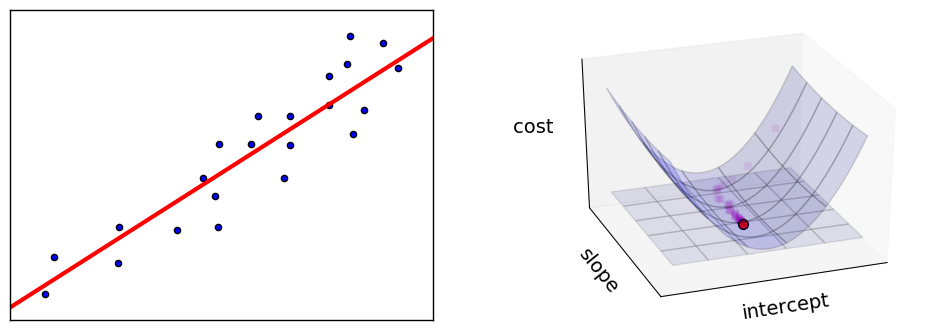

In [2]:
# import statements
%matplotlib inline
import sys
# sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = '../../demo_datasets/toy_regression_data.csv'
demo = regression_1dim_sliders()
demo.load_data(csvname)

# run gradient descent
demo.run_lin_regression_grad_descent(inits = [-2.5,-2.5],max_its = 60)

# run slider
demo.fitting_slider(xlabel = 'intercept', ylabel= 'slope', view = [30,70], fit_type = 'line fit')

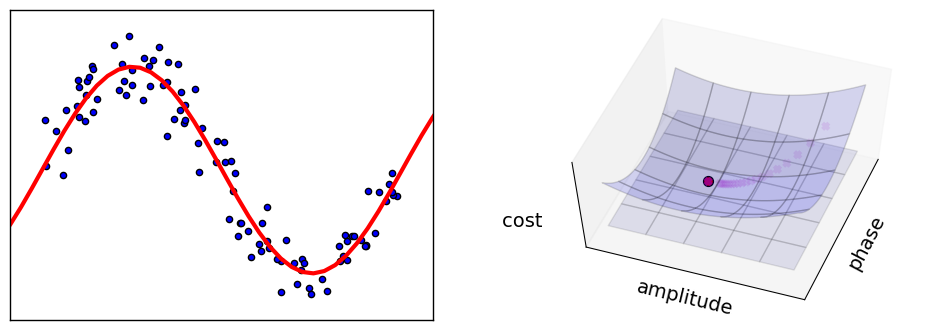

In [21]:
# import statements
%matplotlib inline
import sys
# sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = 'sinusoidal_data.csv'
demo = regression_1dim_sliders()
demo.load_data(csvname,'sin')

# run gradient descent
demo.run_lin_regression_grad_descent(inits = [-2.5,2.5],max_its = 30)

# run slider
demo.fitting_slider(xlabel = 'phase', ylabel= 'amplitude',view = [60,20], fit_type = 'sine fit')

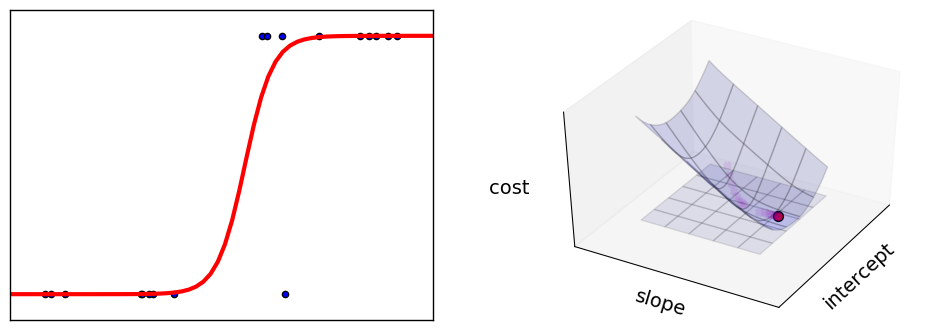

In [22]:
# import statements
%matplotlib inline
import sys
# sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = 'logistic_1dim_dataset.csv'
demo = regression_1dim_sliders()
demo.load_data(csvname,'logistic')

# run gradient descent
demo.run_logistic_regression_grad_descent(inits = [-2.5,-2.5],max_its = 20)

# run slider
demo.fitting_slider(xlabel = 'intercept', ylabel= 'slope',view = [40,30], fit_type = 'logistic fit')

In [23]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
import os
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets
from IPython.display import clear_output
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
# -*- coding: utf-8 -*-

class classification_sliders:
    
    def __init__(self):
        a = 0
        self.X = []
        self.y = []
        self.cost_history = []
        self.x_orig = []
        
    # load in a two-dimensional dataset from csv - input should be in first column, oiutput in second column, no headers 
    def load_data(self,*args):
        # load data
        data = np.asarray(pd.read_csv(args[0],header = None))
    
        # import data and reshape appropriately
        X = data[:,0:-1]
        y = data[:,-1]
        y.shape = (len(y),1)
        self.y = y
        
        # pad data with ones for more compact gradient computation
        o = np.ones((np.shape(X)[0],1))
        X = np.concatenate((o,X),axis = 1)
        self.X = X.T        
      
    #### logistic regression functions ####
    # function for computing logistic regression cost function value
    def compute_logistic_regression_cost(self,X,y,w):
        cost = 0
        for p in range(0,len(y)):
            x_p = X[:,p]
            y_p = y[p]
            cost += np.log(1 + np.exp(-y_p*(np.dot(x_p.T,w))))
        return cost[0]
    
    # function for computing the softmax cost gradient
    def compute_gradient(self,X,y,w):
        # produce gradient for each class weights
        grad = 0
        for p in range(0,len(y)):
            x_p = X[:,p]
            y_p = y[p]
            grad+= -1/(1 + np.exp(y_p*np.dot(x_p.T,w)))*y_p*x_p

        grad.shape = (len(grad),1)
        return grad

    # gradient descent function for softmax cost/logistic regression 
    def run_logistic_regression_grad_descent(self,inits,max_its):        
        # compute cost function value 
        w = np.asarray(inits)
        w.shape = (len(w),1)
        cost_val = self.compute_logistic_regression_cost(self.X,self.y,w)
        temp = [v for v in w]
        temp.append(cost_val)
        self.cost_history.append(temp) 
        
        for k in range(max_its):
            # compute gradient
            grad = self.compute_gradient(self.X,self.y,w)
            
            # compute step length
            alpha = self.line_search(self.X,self.y,w,grad,self.compute_logistic_regression_cost)
            
            # take descent step
            w = w - alpha*grad;
        
            # compute cost function value 
            cost_val = self.compute_logistic_regression_cost(self.X,self.y,w)
            temp = [v for v in w]
            temp.append(cost_val)
            self.cost_history.append(temp) 

            
    #### line search module - used for with both linear regression and logistic regression grad descent functions ####
    def line_search(self,X,y,w,grad,cost_fun):
        alpha = 1
        t = 0.05
        g_w = cost_fun(X,y,w)
        norm_w = np.linalg.norm(grad)**2
        
        # determine step length
        while cost_fun(X,y,w - alpha*grad) > g_w - alpha*0.5*norm_w:
            alpha = t*alpha
        return alpha

    ##### plotting functions ####
    # show the net transformation using slider
    def dim1_fitting_slider(self,**args):  
        # pull out coordinates
        x = self.X[1,:]
        y = self.y
        
        ##### precomputations #####
        # precompute fits input
        x_fit = np.linspace(np.min(x)-1, np.max(x)+1, 100)
        
        # precompute surface 
        xs = max([abs(v[0]) for v in self.cost_history])
        ys = max([abs(v[1]) for v in self.cost_history])
        minval = min(-xs,-ys)
        maxval = max(xs,ys)
        gap = (maxval - minval)*0.2
        r = np.linspace(minval - gap, maxval + gap)    
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))

        # generate surface based on given data - done very lazily - recomputed each time
        g = 0
        P = len(y)
        for p in range(0,P):
            g+= np.log(1 + np.exp(-y[p]*(s + t*x[p])))

        # reshape and plot the surface, as well as where the zero-plane is
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        g.shape = (np.size(r),np.size(r))
        
        # slider mechanism
        ##### start plotting #####  
        def show_fit(step):
            fig = plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')

            ### initialize plot data points and fit
            # initialize fit
            vals = self.cost_history[step]
            b = vals[0]
            w = vals[1]
            
            #### print left panel ####
            # transform input if needed for plotting
            y_fit = np.tanh(b + x_fit*w)

            # plot fit to data
            a = plt.subplot(131)
            a.plot(x_fit,y_fit,'-k',linewidth = 3,zorder= 0) 

            # initialize points
            pos_inds = np.argwhere(y > 0)
            pos_inds = [v[0] for v in pos_inds]
            a.scatter(x[pos_inds],y[pos_inds],color = 'salmon',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            neg_inds = np.argwhere(y < 0)
            neg_inds = [v[0] for v in neg_inds]
            a.scatter(x[neg_inds],y[neg_inds],color = 'cornflowerblue',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            # clean up panel
            xgap = float(max(x) - min(x))/float(10)
            a.set_xlim([min(x)-xgap,max(x)+xgap])
            ygap = float(max(y) - min(y))/float(10)
            a.set_ylim([min(y)-ygap,max(y)+ygap])
            a.set_xticks([])
            a.set_yticks([])
            a.set_title('logistic fit')

            #### print middle panel ####
            # plot fit to data
            a = plt.subplot(132)

            y_fit = np.sign(b + x_fit*w)
            a.plot(x_fit,y_fit,'-k',linewidth = 3,zorder= 0) 

            # initialize points
            pos_inds = np.argwhere(y > 0)
            pos_inds = [v[0] for v in pos_inds]
            a.scatter(x[pos_inds],y[pos_inds],color = 'salmon',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            neg_inds = np.argwhere(y < 0)
            neg_inds = [v[0] for v in neg_inds]
            a.scatter(x[neg_inds],y[neg_inds],color = 'cornflowerblue',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            # clean up panel
            xgap = float(max(x) - min(x))/float(10)
            a.set_xlim([min(x)-xgap,max(x)+xgap])
            ygap = float(max(y) - min(y))/float(10)
            a.set_ylim([min(y)-ygap,max(y)+ygap])
            a.set_xticks([])
            a.set_yticks([])     
            a.set_title('final classifier')
            
            #### print right panel ####
            a = plt.subplot(133,projection='3d')
            a.plot_surface(s,t,g,alpha = 0.15)
            a.plot_surface(s,t,g*0,alpha = 0.1)

            # plot all gradient descent steps faintly for visualization purposes
            bs = []
            ws = []
            costs = []
            for i in range(len(self.cost_history)):
                bwg = self.cost_history[i]
                b = bwg[0]
                w = bwg[1]
                cost = bwg[2]
                bs.append(b)
                ws.append(w)
                costs.append(cost)
            a.scatter(bs,ws,costs,color = 'm',marker = 'x',linewidth = 3, alpha = 0.1)            

            # plot current gradient descent step in bright red
            b = vals[0]
            w = vals[1]
            cost = vals[2]
            a.scatter(b,w,cost,marker = 'o',color = 'r',s = 60,edgecolor = 'k',linewidth = 4)            
            
            # clean up panel
            a.view_init(args['view'][0],args['view'][1])        
            a.set_xticks([])
            a.set_yticks([])
            a.set_zticks([])
            a.set_title('cost function')
            
            a.set_xlabel(args['xlabel'],fontsize = 14,labelpad = -5)
            a.set_ylabel(args['ylabel'],fontsize = 14,labelpad = -5)

            a.zaxis.set_rotate_label(False)  # disable automatic rotation
            a.set_zlabel('cost  ',fontsize = 14, rotation = 0,labelpad = 1)
            
            plt.show()
        interact(show_fit, step=widgets.IntSlider(min=0,max=len(self.cost_history)-1,step=1,value=0))
    
    def plot_approx(clf,data,labels):
        colors = ['salmon','cornflowerblue','lime','bisque','mediumaquamarine','b','m','g']

        # plot classification boundary and color regions appropriately
        lower_bound = min(data.ravel())
        upper_bound = max(data.ravel())
        r = np.linspace(lower_bound - 0.1,upper_bound + 0.1,700)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),1)

        # use classifier to make predictions
        z = clf.predict(h)

        # reshape predictions for plotting
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))

        unique_labels = np.unique(labels)
        levels = unique_labels
        plt.contourf(s,t,z,colors = colors[0:len(unique_labels)+1], levels = range(0,len(unique_labels)+1), alpha = 0.2)

        # show the classification boundary if it exists
        if len(np.unique(z)) > 1:
            plt.contour(s,t,z,colors = 'k',linewidths = 2.5, levels = unique_labels)
    
    # show the net transformation using slider
    def dim2_fitting_slider(self,**args):  
        # setup range for plots
        costs = [v[-1] for v in self.cost_history]
        X = self.X
        y = self.y
        xgap = float(max(X[1,:]) - min(X[1,:]))/float(10)
        ygap = float(max(X[2,:]) - min(X[2,:]))/float(10)
            
        # take positive and negative label indicies
        pos_inds = np.argwhere(y > 0)
        pos_inds = [v[0] for v in pos_inds]
    
        neg_inds = np.argwhere(y < 0)
        neg_inds = [v[0] for v in neg_inds]
        
        # setup surface data for left and middle plot
        colors = ['salmon','cornflowerblue','lime','bisque','mediumaquamarine','b','m','g']

        # plot classification boundary and color regions appropriately
        lower_bound = min(data.ravel())
        upper_bound = max(data.ravel())
        r = np.linspace(lower_bound - 0.1,upper_bound + 0.1,700)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),1)

        # use classifier to make predictions
        z = clf.predict(h)
        
        # slider mechanism
        def show_fit(step):
            ##### start plotting #####  
            fig = plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')

            #### print left panel ####
            ax1 = plt.subplot(131)
            ax1.scatter(X[1,pos_inds],X[2,pos_inds],color = 'salmon',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)
            ax1.scatter(X[1,neg_inds],X[2,neg_inds],color = 'cornflowerblue',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            # clean up panel
            ax1.set_xlim([min(X[1,:])-xgap,max(X[1,:])+xgap])
            ax1.set_ylim([min(X[2,:])-ygap,max(X[2,:])+ygap])
            ax1.set_xticks([])
            ax1.set_yticks([])   
            
            #### print middle panel ####
            ax2 = plt.subplot(132,projection='3d')
            ax2.scatter(X[1,pos_inds],X[2,pos_inds],y[pos_inds],color = 'salmon',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)
            ax2.scatter(X[1,neg_inds],X[2,neg_inds],y[neg_inds],color = 'cornflowerblue',linewidth = 1,marker = 'o',edgecolor = 'k',s = 80)

            # clean up panel
            ax2.set_xlim([min(X[1,:])-xgap,max(X[1,:])+xgap])
            ax2.set_ylim([min(X[2,:])-ygap,max(X[2,:])+ygap])
            ax2.set_xticks([])
            ax2.set_yticks([])     
            
            #### print right panel #### 
            # print all of the step cost function values lightly
            ax3 = plt.subplot(133)
            ax3.plot(costs,color = 'm',marker = 'o',linewidth = 3, alpha = 0.1)            

            # print current value 
            ax3.scatter(step,costs[step],marker = 'o',color = 'r',s = 60,edgecolor = 'k',linewidth = 2)            
            
            # dress up plot 
            ax3.set_xlabel('step',fontsize=15,labelpad = 5)
            ax3.set_ylabel('cost function value',fontsize=12,rotation = 90,labelpad = 5)
            ax3.set_xticks([])
            ax3.set_yticks([])
        interact(show_fit, step=widgets.IntSlider(min=0,max=len(self.cost_history)-1,step=1,value=0))

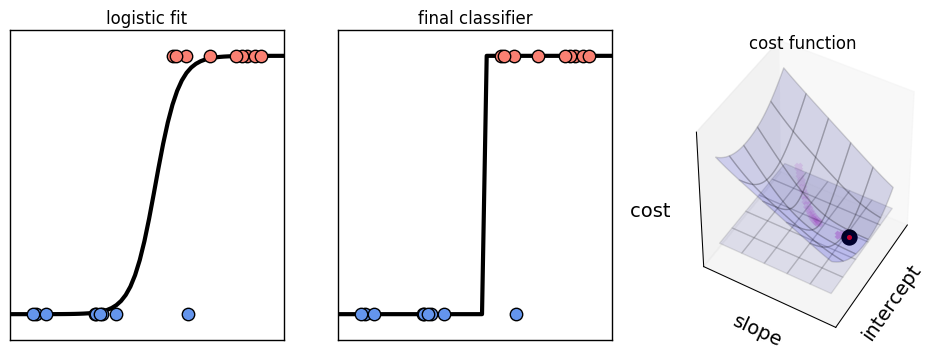

In [24]:
# import statements
%matplotlib inline
import sys
# sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = 'logistic_1dim_dataset.csv'
demo = classification_sliders()
demo.load_data(csvname)

# run gradient descent
demo.run_logistic_regression_grad_descent(inits = [-2.5,-2.5],max_its = 20)

#run slider
demo.dim1_fitting_slider(xlabel = 'intercept', ylabel= 'slope',view = [40,30], fit_type = 'logistic fit')

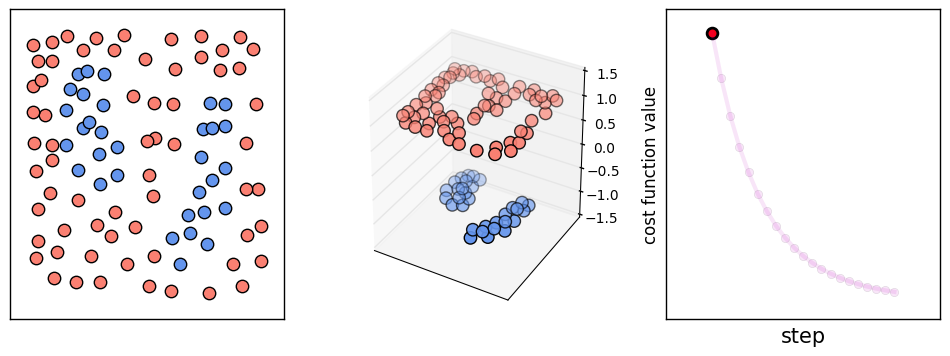

In [25]:
# import statements
%matplotlib inline
import sys
# sys.path.append('../../demo_python_backend_files')
from IPython import display            

# call the demonstration
csvname = '2eggs_dataset.csv'
demo = classification_sliders()
demo.load_data(csvname)

# run gradient descent
demo.run_logistic_regression_grad_descent(inits = [0,0,0],max_its = 20)

#run slider
demo.dim2_fitting_slider(xlabel = 'intercept', ylabel= 'slope',view = [40,30], fit_type = 'logistic fit')